<a href="https://colab.research.google.com/github/Snake-AID/SnakeAid.ComputerVision/blob/main/SnakeTraining_V5_YOLOv12_Khiem_Bbox5000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Snake-AID/SnakeAid.ComputerVision/blob/main/SnakeTraining_V4_YOLOv12_Khiem_Bbox5000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [33]:
!nvidia-smi

Sat Dec 13 20:32:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             29W /   70W |    5466MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [34]:
import os
from datetime import datetime, timedelta, timezone

HOME = os.getcwd()
print(f"📂 HOME: {HOME}")

PROJECT_NAME = "SnakeTraining"
VERSION      = "V4-1"
MODEL_ARCH   = "YOLOv12"
AUTHOR       = "Khiem"
DATA_INFO    = "Bbox5291"

# Lấy thời gian hiện tại theo múi giờ UTC+7
utc_plus_7 = timezone(timedelta(hours=7))
current_time = datetime.now(utc_plus_7).strftime("%Y%m%d_%H%M")

# Ghép chuỗi tên model kèm timestamp
notebook_name = f"{PROJECT_NAME}_{VERSION}_{MODEL_ARCH}_{AUTHOR}_{DATA_INFO}_{current_time}"

print(f"📘 Configured Model Name: {notebook_name}")

📂 HOME: /content

📘 Configured Model Name: SnakeTraining_V4-1_YOLOv12_Khiem_Bbox5291_20251214_0332

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Dataset Paths

In [36]:
import os
import shutil
import yaml
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

# --- CONFIG ---
DRIVE_DATASET_PATH = '/content/drive/MyDrive/SnakeDataset/SnakeAid-YOLOv12-5291BBox'
DATASET_PATH = '/content/snake_dataset'
DATA_YAML_PATH = f'{DATASET_PATH}/data.yaml'

def check_dataset_integrity(path):
    """Kiểm tra thông minh: Trả về True nếu data đã đầy đủ"""
    # 1. Check file cấu hình
    if not os.path.exists(f"{path}/data.yaml"):
        return False

    # 2. Check các folder quan trọng (train, valid, test)
    # Nếu bất kỳ folder nào thiếu hoặc rỗng -> coi như lỗi -> copy lại
    required_dirs = [
        'train/images', 'train/labels',
        'valid/images', 'valid/labels',
        'test/images', 'test/labels'
    ]

    for d in required_dirs:
        dir_path = os.path.join(path, d)
        if not os.path.exists(dir_path):
            return False
        if not os.listdir(dir_path): # Folder rỗng
            return False

    return True

def copy_file_worker(args):
    """Hàm worker để copy 1 file (dùng cho đa luồng)"""
    src, dst = args
    try:
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy2(src, dst)
    except Exception as e:
        # Có thể log error nếu cần
        pass

def fast_copy_multithread(src_root, dst_root, workers=16):
    """Copy dữ liệu sử dụng đa luồng để tối ưu I/O"""
    if os.path.exists(dst_root):
        print(f"🗑️ Phát hiện dữ liệu không toàn vẹn. Đang xóa {dst_root}...")
        shutil.rmtree(dst_root)

    print("🔍 Đang quét danh sách file nguồn (Scanning)...")
    files_to_copy = []
    for root, dirs, files in os.walk(src_root):
        for file in files:
            src_file = os.path.join(root, file)
            rel_path = os.path.relpath(src_file, src_root)
            dst_file = os.path.join(dst_root, rel_path)
            files_to_copy.append((src_file, dst_file))

    print(f"🚀 Tìm thấy {len(files_to_copy)} files. Bắt đầu copy tốc độ cao (16 threads)...")

    # ThreadPoolExecutor giúp request nhiều file cùng lúc từ Drive
    with ThreadPoolExecutor(max_workers=workers) as executor:
        list(tqdm(executor.map(copy_file_worker, files_to_copy), total=len(files_to_copy), unit="file"))

# --- MAIN FLOW ---
if check_dataset_integrity(DATASET_PATH):
    print("✅ Smart Check: Dữ liệu đã đầy đủ và hợp lệ tại Local. (Skipped Copy)")
else:
    print(f"⚠️ Smart Check: Dữ liệu thiếu hoặc chưa có. Tiến hành copy...")
    try:
        fast_copy_multithread(DRIVE_DATASET_PATH, DATASET_PATH)

        # Cập nhật đường dẫn trong data.yaml
        if os.path.exists(DATA_YAML_PATH):
            with open(DATA_YAML_PATH, 'r') as f:
                data_config = yaml.safe_load(f)

            data_config['path'] = DATASET_PATH
            # Fix đường dẫn relative
            for key in ['train', 'val', 'test']:
                if key in data_config and isinstance(data_config[key], str):
                    if 'drive' in data_config[key].lower():
                        folder = 'valid' if key == 'val' else key
                        data_config[key] = f'{folder}/images'

            with open(DATA_YAML_PATH, 'w') as f:
                yaml.dump(data_config, f)
            print("✅ Cấu hình data.yaml hoàn tất!")
        else:
            print("⚠️ Không tìm thấy data.yaml sau khi copy!")

    except Exception as e:
        print(f"❌ Lỗi khi copy: {e}")

✅ Smart Check: Dữ liệu đã đầy đủ và hợp lệ tại Local. (Skipped Copy)

In [37]:
from rich import print
from rich.panel import Panel
from rich.table import Table
from rich import box
import os

def check_dataset(root, folders=("train", "valid", "test")):
    table = Table(
        title="Dataset Structure",
        box=box.SIMPLE_HEAD,
        show_lines=False,
        pad_edge=False
    )

    table.add_column("Component", style="bold cyan", justify="center")
    table.add_column("Status/Images", justify="center")
    table.add_column("Labels", justify="center")

    missing_files = False

    yaml_path = os.path.join(root, "data.yaml")
    yaml_exists = os.path.exists(yaml_path)

    if not yaml_exists:
        missing_files = True

    table.add_row(
        "data.yaml",
        "[green]FOUND" if yaml_exists else "[red]MISSING",
        "-"
    )

    for folder in folders:
        fp = os.path.join(root, folder)
        img = os.path.join(fp, "images")
        lbl = os.path.join(fp, "labels")

        img_exists = os.path.exists(img)
        lbl_exists = os.path.exists(lbl)

        if not img_exists or not lbl_exists:
            missing_files = True

        table.add_row(
            folder.upper(),
            "[green]FOUND" if img_exists else "[red]MISSING",
            "[green]FOUND" if lbl_exists else "[red]MISSING",
        )

    panel = Panel.fit(
        table,
        title="🐍 Snake Dataset Check",
        border_style="cyan",
        box=box.SIMPLE
    )

    print(panel)

    if missing_files:
        raise FileNotFoundError("Dataset structure is incomplete! Please check your dataset path and structure.")

check_dataset(DATASET_PATH)

         🐍 Snake Dataset Check         
           Dataset Structure            
                                        
   Component   Status/Images   Labels   
   ──────────────────────────────────   
   data.yaml       FOUND         -      
     TRAIN         FOUND       FOUND    
     VALID         FOUND       FOUND    
     TEST          FOUND       FOUND    
                                        
                                        

# Install YOLOv12 and SuperVision

## Install essential python package

In [38]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git supervision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Test the base models

### Download example data

In [39]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-12-13 20:32:52--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg.2’

dog.jpeg.2          100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-12-13 20:32:52 (159 MB/s) - ‘dog.jpeg.2’ saved [106055/106055]



### Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

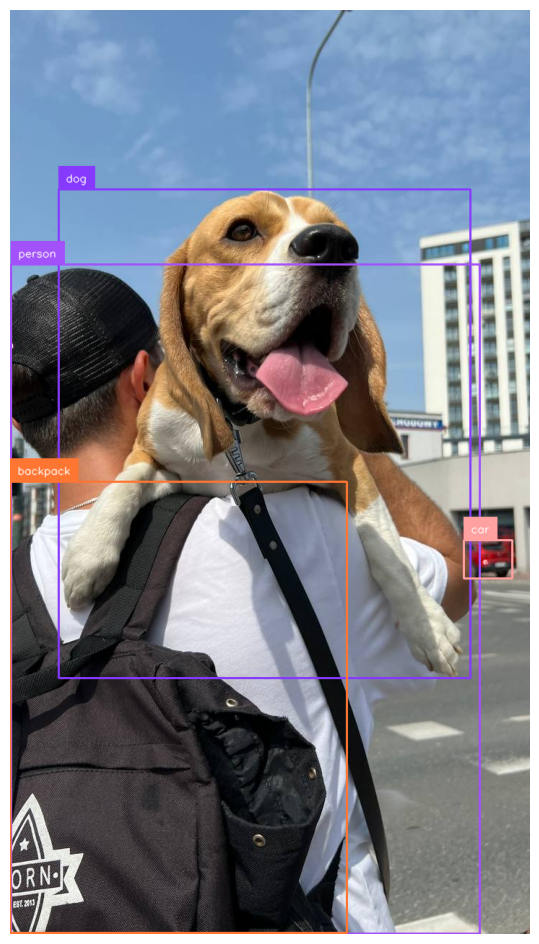

In [40]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

# Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [41]:
# from ultralytics import YOLO

# model = YOLO('yolov12m.pt')
# results = model.train(data=DATA_YAML_PATH, epochs=100, patience=10, cache=True)

### GPU detect (auto select profile)

**Imports**

In [42]:
import os
import torch

from rich import print
from rich.panel import Panel
from rich.table import Table
from rich import box

**Helpers + Rich logger**

In [43]:
def is_kaggle_env() -> bool:
    # Kaggle notebooks always set this
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ

def log_gpu_info():
    table = Table(
        title="GPU Runtime Information",
        box=box.SIMPLE_HEAVY,
        show_header=True,
        header_style="bold cyan"
    )
    table.add_column("Metric", style="bold")
    table.add_column("Value")

    if not torch.cuda.is_available():
        table.add_row("CUDA Available", "❌ No")
        table.add_row("GPU Count", "0")
        print(table)
        return

    idx = torch.cuda.current_device()
    props = torch.cuda.get_device_properties(idx)

    total_gb = props.total_memory / (1024**3)
    reserved_gb = torch.cuda.memory_reserved(idx) / (1024**3)
    allocated_gb = torch.cuda.memory_allocated(idx) / (1024**3)
    free_gb = total_gb - reserved_gb

    table.add_row("CUDA Available", "✅ Yes")
    table.add_row("GPU Name", props.name)
    table.add_row("GPU Count", str(torch.cuda.device_count()))
    table.add_row("VRAM Total", f"{total_gb:.2f} GB")
    table.add_row("VRAM Reserved", f"{reserved_gb:.2f} GB")
    table.add_row("VRAM Allocated", f"{allocated_gb:.2f} GB")
    table.add_row("VRAM Free (approx)", f"{free_gb:.2f} GB")

    print(table)

**Main detection (select profile)**

In [44]:
def select_training_profile():
    kaggle = is_kaggle_env()

    env_name = "Kaggle" if kaggle else "Colab / Other"
    print(
        Panel.fit(
            f"[bold]Environment:[/bold] {env_name}",
            title="Runtime Environment",
            border_style="green"
        )
    )

    # Log GPU info (log only)
    log_gpu_info()

    if not torch.cuda.is_available():
        return "CPU"

    gpu_name = torch.cuda.get_device_name(0).lower()

    # Kaggle mapping
    if kaggle:
        if "p100" in gpu_name:
            return "KAGGLE_P100"
        if "t4" in gpu_name:
            return "KAGGLE_T4X2"
        return "KAGGLE_P100"

    # Colab mapping
    if "a100" in gpu_name:
        return "A100"
    if "l4" in gpu_name:
        return "L4"
    if "t4" in gpu_name:
        return "T4"

    return "T4"


TRAIN_PROFILE = select_training_profile()

print(
    Panel.fit(
        f"[bold cyan]Selected training profile:[/bold cyan] [bold yellow]{TRAIN_PROFILE}[/bold yellow]",
        title="Profile Selection",
        border_style="cyan"
    )
)

╭─── Runtime Environment ────╮
│ Environment: Colab / Other │
╰────────────────────────────╯

     GPU Runtime Information     
                                 
  Metric               Value     
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  CUDA Available       ✅ Yes    
  GPU Name             Tesla T4  
  GPU Count            1         
  VRAM Total           14.74 GB  
  VRAM Reserved        5.14 GB   
  VRAM Allocated       0.36 GB   
  VRAM Free (approx)   9.60 GB

╭────── Profile Selection ──────╮
│ Selected training profile: T4 │
╰───────────────────────────────╯

### Training config dictionary (profiles)

### Param Config

#### `epochs=200`

* **Chức năng:** Xác định số vòng lặp huấn luyện tối đa mà mô hình sẽ chạy trên toàn bộ tập dữ liệu.
* **Lý do lựa chọn:** Với đối tượng rắn thường nhỏ và khó phân biệt với nền, các chỉ số như mAP và Recall thường cải thiện muộn, vì vậy cần nhiều epoch hơn mức mặc định (100) để mô hình hội tụ đầy đủ.

---

#### `patience=40`

* **Chức năng:** Điều khiển cơ chế early stopping, mô hình sẽ dừng huấn luyện nếu metric validation không cải thiện sau số epoch này.
* **Lý do lựa chọn:** Trong bài toán SnakeAid, metric thường dao động mạnh do vật thể nhỏ và nền phức tạp, nên đặt patience cao để tránh dừng huấn luyện quá sớm khi mô hình chưa đạt trạng thái tối ưu.

---

#### `imgsz=896`

* **Chức năng:** Thiết lập độ phân giải ảnh đầu vào cho quá trình huấn luyện.
* **Lý do lựa chọn:** Rắn trong ảnh thường chiếm rất ít pixel, tăng độ phân giải giúp mô hình giữ lại nhiều chi tiết không gian hơn, từ đó cải thiện khả năng phát hiện rắn nhỏ hoặc ở xa.

---

#### `batch=16`

* **Chức năng:** Xác định số lượng ảnh được xử lý trong một bước cập nhật gradient.
* **Lý do lựa chọn:** Batch size vừa phải giúp cân bằng giữa độ ổn định của gradient và khả năng học các vật thể nhỏ, tránh hiện tượng làm mượt quá mức khi batch quá lớn.

---

#### `cache=True`

* **Chức năng:** Lưu dữ liệu huấn luyện vào bộ nhớ đệm để tăng tốc độ đọc dữ liệu.
* **Lý do lựa chọn:** Dataset được lưu trên Google Drive khi train bằng Colab, việc bật cache giúp giảm độ trễ I/O và rút ngắn thời gian huấn luyện tổng thể.

---

#### `workers=8`

* **Chức năng:** Xác định số tiến trình CPU song song được sử dụng để đọc dữ liệu, tiền xử lý ảnh và áp dụng các augmentation trước khi dữ liệu được đưa vào GPU trong quá trình huấn luyện.
* **Lý do lựa chọn:** Với ảnh độ phân giải cao (`imgsz=896`) và dữ liệu lưu trên Google Drive khi huấn luyện bằng Colab A100, việc sử dụng `workers=8` giúp tận dụng hiệu quả tài nguyên CPU, tránh tình trạng GPU phải chờ dữ liệu và đảm bảo tốc độ huấn luyện ổn định cho bài toán nhận diện rắn nhỏ và ở xa.

---

#### `cos_lr=True`

* **Chức năng:** Sử dụng chiến lược giảm learning rate theo hàm cosine trong quá trình huấn luyện.
* **Lý do lựa chọn:** Cosine learning rate giúp fine-tune mượt hơn ở các epoch sau, giảm nguy cơ dao động mạnh và giúp mô hình ổn định khi tối ưu cho các vật thể nhỏ.

In [45]:
CONFIGS = {

    # Quick sanity / pipeline check
    "DEBUG": dict(
        epochs=1,
        patience=0,
        imgsz=512,
        batch=2,
        accumulate=1,
        cache=False,
        workers=1,
    ),

    # CPU-only
    "CPU": dict(
        epochs=120,
        patience=30,
        imgsz=640,
        batch=2,
        accumulate=4,     # effective batch = 8
        cache="disk",
        workers=2,
    ),

    # Colab Free (Tesla T4 16GB VRAM)
    "T4": dict(
        epochs=80,
        patience=20,
        imgsz=768,
        batch=4,
        accumulate=2,     # effective batch = 8
        cache="disk",
        workers=2,
    ),

    # Kaggle GPU P100 (16GB VRAM)
    "KAGGLE_P100": dict(
        epochs=80,
        patience=20,
        imgsz=768,
        batch=4,
        accumulate=2,     # effective batch = 8
        cache="disk",
        workers=2,
    ),

    # Kaggle GPU T4 x2 (treated as single T4 unless DDP enabled)
    "KAGGLE_T4X2": dict(
        epochs=80,
        patience=20,
        imgsz=768,
        batch=4,
        accumulate=2,     # effective batch = 8
        cache="disk",
        workers=2,
    ),

    # Colab Pro (NVIDIA L4 24GB VRAM)
    "L4": dict(
        epochs=120,
        patience=25,
        imgsz=768,
        batch=8,
        accumulate=1,
        cache=True,
        workers=4,
    ),

    # Colab Pro (A100 40GB VRAM)
    "A100": dict(
        epochs=200,
        patience=40,
        imgsz=896,
        batch=16,
        accumulate=1,
        cache=True,
        workers=8,
    ),
}

cfg = CONFIGS[TRAIN_PROFILE]

print("🧠 Loaded training configuration:")
for k, v in cfg.items():
    print(f"  {k}: {v}")

🧠 Loaded training configuration:

epochs: 80

patience: 20

imgsz: 768

batch: 4

accumulate: 2

cache: disk

workers: 2

### Param Config

#### `mixup=0.0`

* **Chức năng:** Điều chỉnh mức độ sử dụng augmentation mixup (trộn hai ảnh và nhãn).
* **Lý do lựa chọn:** Mixup có thể tạo ra các hình ảnh không thực tế đối với đối tượng dài và mảnh như rắn, làm giảm chất lượng học, vì vậy được tắt hoàn toàn trong bài toán này.

---

#### `copy_paste=0.0`

* **Chức năng:** Điều khiển augmentation copy-paste, trong đó đối tượng được cắt và dán sang ảnh khác.
* **Lý do lựa chọn:** Copy-paste có thể tạo ra các vị trí rắn không tự nhiên trong ảnh, gây nhiễu cho mô hình, nên được tắt để giữ tính thực tế của dữ liệu huấn luyện.

In [46]:
from ultralytics import YOLO

# Load pretrained model
model = YOLO("yolov12s.pt")

results = model.train(
    data=(DATA_YAML_PATH),
    project=f"{HOME}/runs/detect",
    name='train',
    exist_ok=True,

    # epochs=cfg["epochs"],
    # patience=cfg["patience"],
    epochs=17,
    patience=0,
    imgsz=cfg["imgsz"],
    batch=cfg["batch"],
    nbs=cfg["batch"] * cfg["accumulate"],
    cache=cfg["cache"],
    workers=cfg["workers"],
    cos_lr=True,

    # Snake-specific augmentation control
    mixup=0.0,
    copy_paste=0.0,
)

print("✅ Training finished")
print(f"📁 Weights saved to: runs/detect/train/weights/")

New https://pypi.org/project/ultralytics/8.3.237 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.pt, data=/content/snake_dataset/data.yaml, epochs=17, time=None, patience=0, batch=4, imgsz=768, save=True, save_period=-1, cache=disk, device=None, workers=2, project=/content/runs/detect, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=F

train: Scanning /content/snake_dataset/train/labels.cache... 4795 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4795/4795 [00:00<?, ?it/s]
train: Caching images (5.5GB Disk): 100%|██████████| 4795/4795 [00:00<00:00, 46230.58it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/snake_dataset/valid/labels.cache... 265 images, 0 backgrounds, 0 corrupt: 100%|██████████| 265/265 [00:00<?, ?it/s]
val: Caching images (0.3GB Disk): 100%|██████████| 265/265 [00:00<00:00, 25066.32it/s]


Plotting labels to /content/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 768 train, 768 val
Using 2 dataloader workers
Logging results to /content/runs/detect/train
Starting training for 17 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/17      5.54G       1.24      3.668      1.796          8        768: 100%|██████████| 1199/1199 [05:51<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:13<00:00,  2.54it/s]

                   all        265        265      0.401      0.151     0.0732     0.0375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/17      3.39G      1.868      3.833      2.341          7        768: 100%|██████████| 1199/1199 [05:28<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  5.79it/s]

                   all        265        265    0.00216      0.543     0.0101    0.00337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/17      3.29G      2.085       4.24      2.554          6        768: 100%|██████████| 1199/1199 [05:18<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.00it/s]


                   all        265        265      0.462     0.0358    0.00554    0.00144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/17      3.38G      2.254      4.567      2.698          6        768: 100%|██████████| 1199/1199 [05:17<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.72it/s]

                   all        265        265    0.00135       0.41    0.00261   0.000631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/17      3.29G      2.159      4.472      2.604          6        768: 100%|██████████| 1199/1199 [05:18<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.77it/s]

                   all        265        265    0.00207      0.512    0.00875    0.00218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/17      3.38G      2.039      4.344      2.483          7        768: 100%|██████████| 1199/1199 [05:17<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.03it/s]

                   all        265        265    0.00311      0.637     0.0149    0.00718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/17       3.3G      1.975      4.211       2.42          7        768: 100%|██████████| 1199/1199 [05:17<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.29it/s]


                   all        265        265    0.00329      0.675     0.0186    0.00945
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/17      3.38G      2.062       3.84      2.767          3        768: 100%|██████████| 1199/1199 [05:14<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.60it/s]

                   all        265        265    0.00412      0.837     0.0239     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/17       3.3G      2.016      3.726      2.717          3        768: 100%|██████████| 1199/1199 [05:15<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]

                   all        265        265    0.00386      0.846     0.0204    0.00779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/17      3.38G      1.961      3.659      2.651          3        768: 100%|██████████| 1199/1199 [05:13<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.63it/s]

                   all        265        265    0.00388      0.865     0.0294      0.014



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/17       3.3G      1.903      3.581        2.6          3        768: 100%|██████████| 1199/1199 [05:14<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  5.99it/s]

                   all        265        265    0.00422      0.869     0.0306     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/17      3.38G      1.861        3.5      2.559          3        768: 100%|██████████| 1199/1199 [05:13<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.63it/s]

                   all        265        265      0.779     0.0457     0.0543     0.0256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/17      3.29G      1.817      3.419      2.508          3        768: 100%|██████████| 1199/1199 [05:14<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  5.98it/s]

                   all        265        265       0.73     0.0672      0.046      0.024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/17      3.38G      1.783      3.342      2.472          3        768: 100%|██████████| 1199/1199 [05:14<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.65it/s]

                   all        265        265      0.694      0.078     0.0566      0.028



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/17      3.29G      1.766      3.305      2.451          3        768: 100%|██████████| 1199/1199 [05:14<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.14it/s]

                   all        265        265      0.683      0.087     0.0613     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/17      3.38G      1.748      3.265      2.424          3        768: 100%|██████████| 1199/1199 [05:14<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.37it/s]


                   all        265        265      0.603      0.105     0.0658     0.0344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/17      3.28G      1.726      3.256      2.406          3        768: 100%|██████████| 1199/1199 [05:14<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:05<00:00,  6.27it/s]

                   all        265        265      0.562       0.12      0.066     0.0336



17 epochs completed in 1.538 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 18.7MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 18.7MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,082,722 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:06<00:00,  5.54it/s]


                   all        265        265      0.403      0.151     0.0732     0.0376
           cap_nia_bac          6          6     0.0425      0.333      0.113     0.0341
           cap_nia_nam         12         12     0.0624      0.667      0.211      0.116
              cap_nong         10         10     0.0666        0.7       0.14     0.0723
          ho_mang_chua         14         14     0.0573     0.0714     0.0397     0.0274
          ho_mang_xiem         51         51      0.101      0.053     0.0614     0.0321
            khiem_vach          7          7     0.0368      0.143      0.163      0.135
              luc_cuom         10         10          1          0     0.0195    0.00857
               luc_nua          8          8          1          0      0.217     0.0918
              luc_xanh         13         13          1          0     0.0817     0.0276
      luc_xanh_duoi_do          8          8     0.0348      0.013      0.138     0.0747
              ran_cuo

✅ Training finished

📁 Weights saved to: runs/detect/train/weights/

### Save model file into google drive

In [47]:
import shutil
import os

# Define the source path of the best trained model
source_path = f'{HOME}/runs/detect/train/weights/best.pt'

# Define the destination directory in Google Drive
destination_dir = '/content/drive/MyDrive/SnakeAIModels'
os.makedirs(destination_dir, exist_ok=True)

# Sử dụng biến 'notebook_name' đã được define ở cell Setup đầu notebook
print(f"💾 Saving model for notebook: {notebook_name}")
destination_filename = f"{notebook_name}.pt"
destination_path = os.path.join(destination_dir, destination_filename)

# Copy the model file to Google Drive
if os.path.exists(source_path):
    shutil.copy(source_path, destination_path)
    print(f"✅ Trained model saved to: {destination_path}")
else:
    print(f"❌ Source model not found at {source_path}. Make sure training has finished successfully.")

💾 Saving model for notebook: SnakeTraining_V4-1_YOLOv12_Khiem_Bbox5291_20251214_0332

✅ Trained model saved to: 
/content/drive/MyDrive/SnakeAIModels/SnakeTraining_V4-1_YOLOv12_Khiem_Bbox5291_20251214_0332.pt

# Evaluate fine-tuned YOLOv12 model

### Inspect Training Output Directory

In [48]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch0.jpg
confusion_matrix_normalized.png			    train_batch1.jpg
confusion_matrix.png				    train_batch2.jpg
events.out.tfevents.1765657637.2efcce6e7505.1649.0  train_batch8393.jpg
events.out.tfevents.1765657719.2efcce6e7505.1649.1  train_batch8394.jpg
events.out.tfevents.1765657975.2efcce6e7505.1649.2  train_batch8395.jpg
F1_curve.png					    val_batch0_labels.jpg
labels_correlogram.jpg				    val_batch0_pred.jpg
labels.jpg					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights
results.png


### Display Confusion Matrix

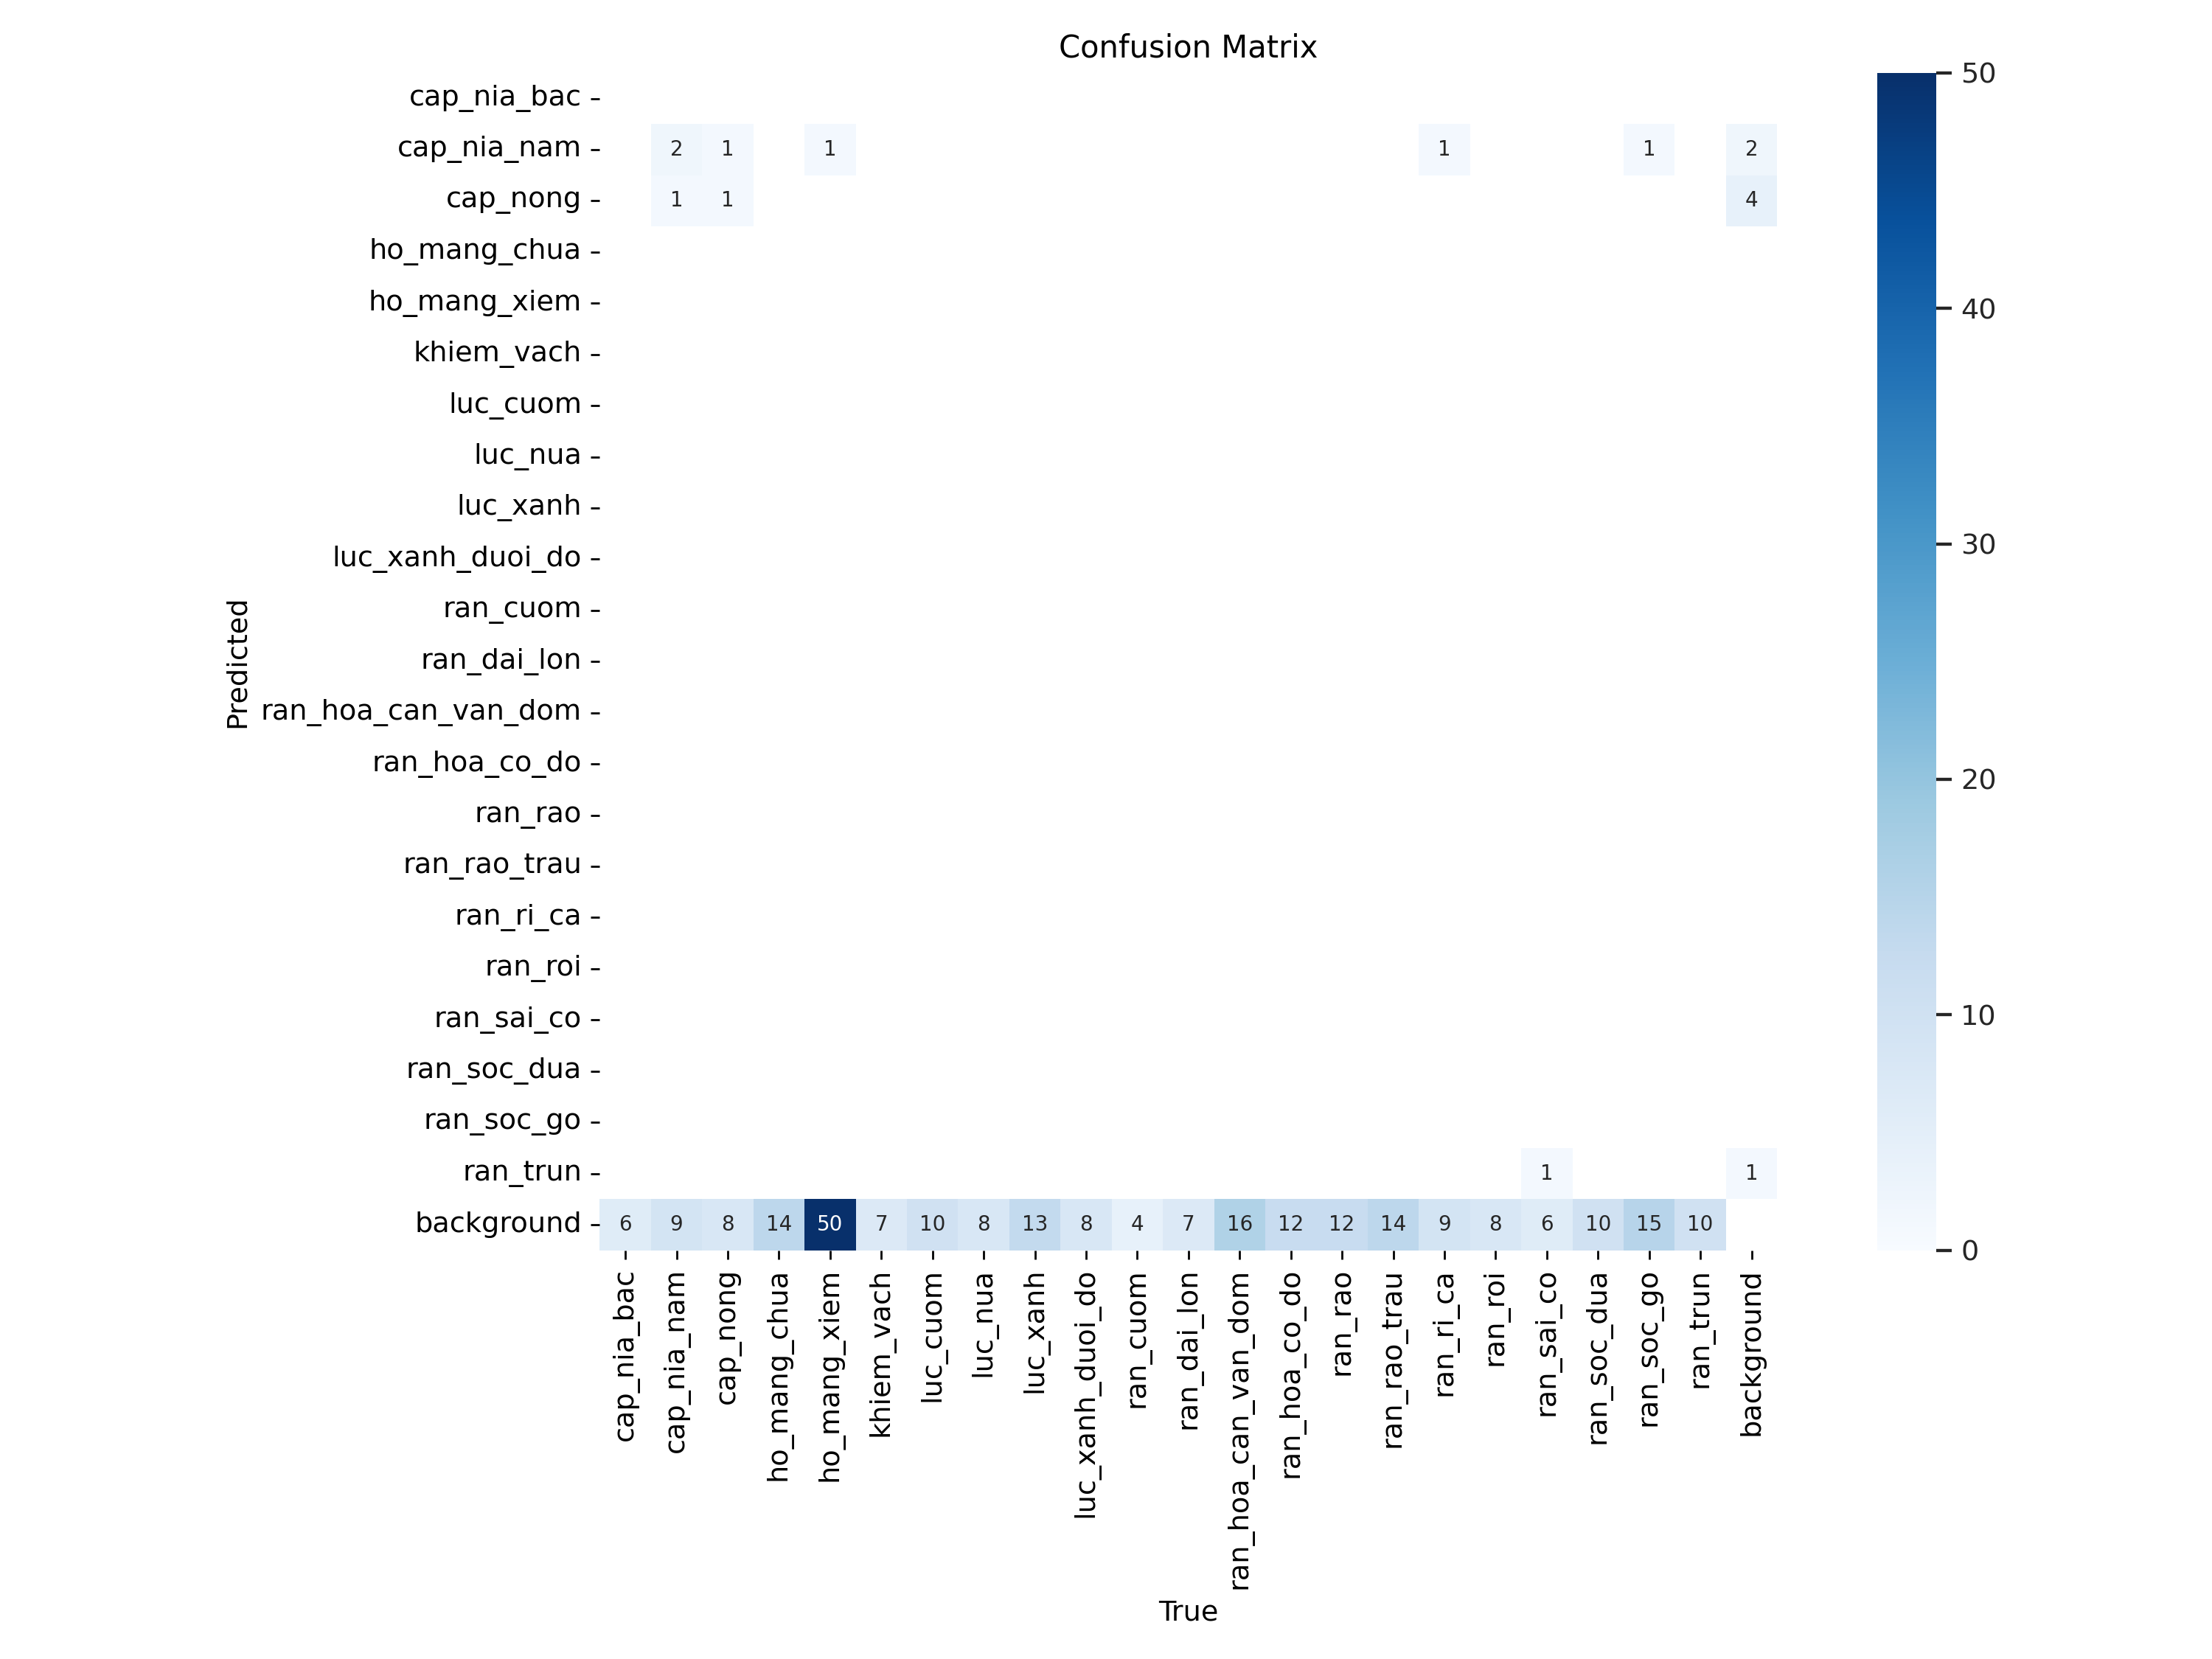

In [49]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

### Display Training Results Plot

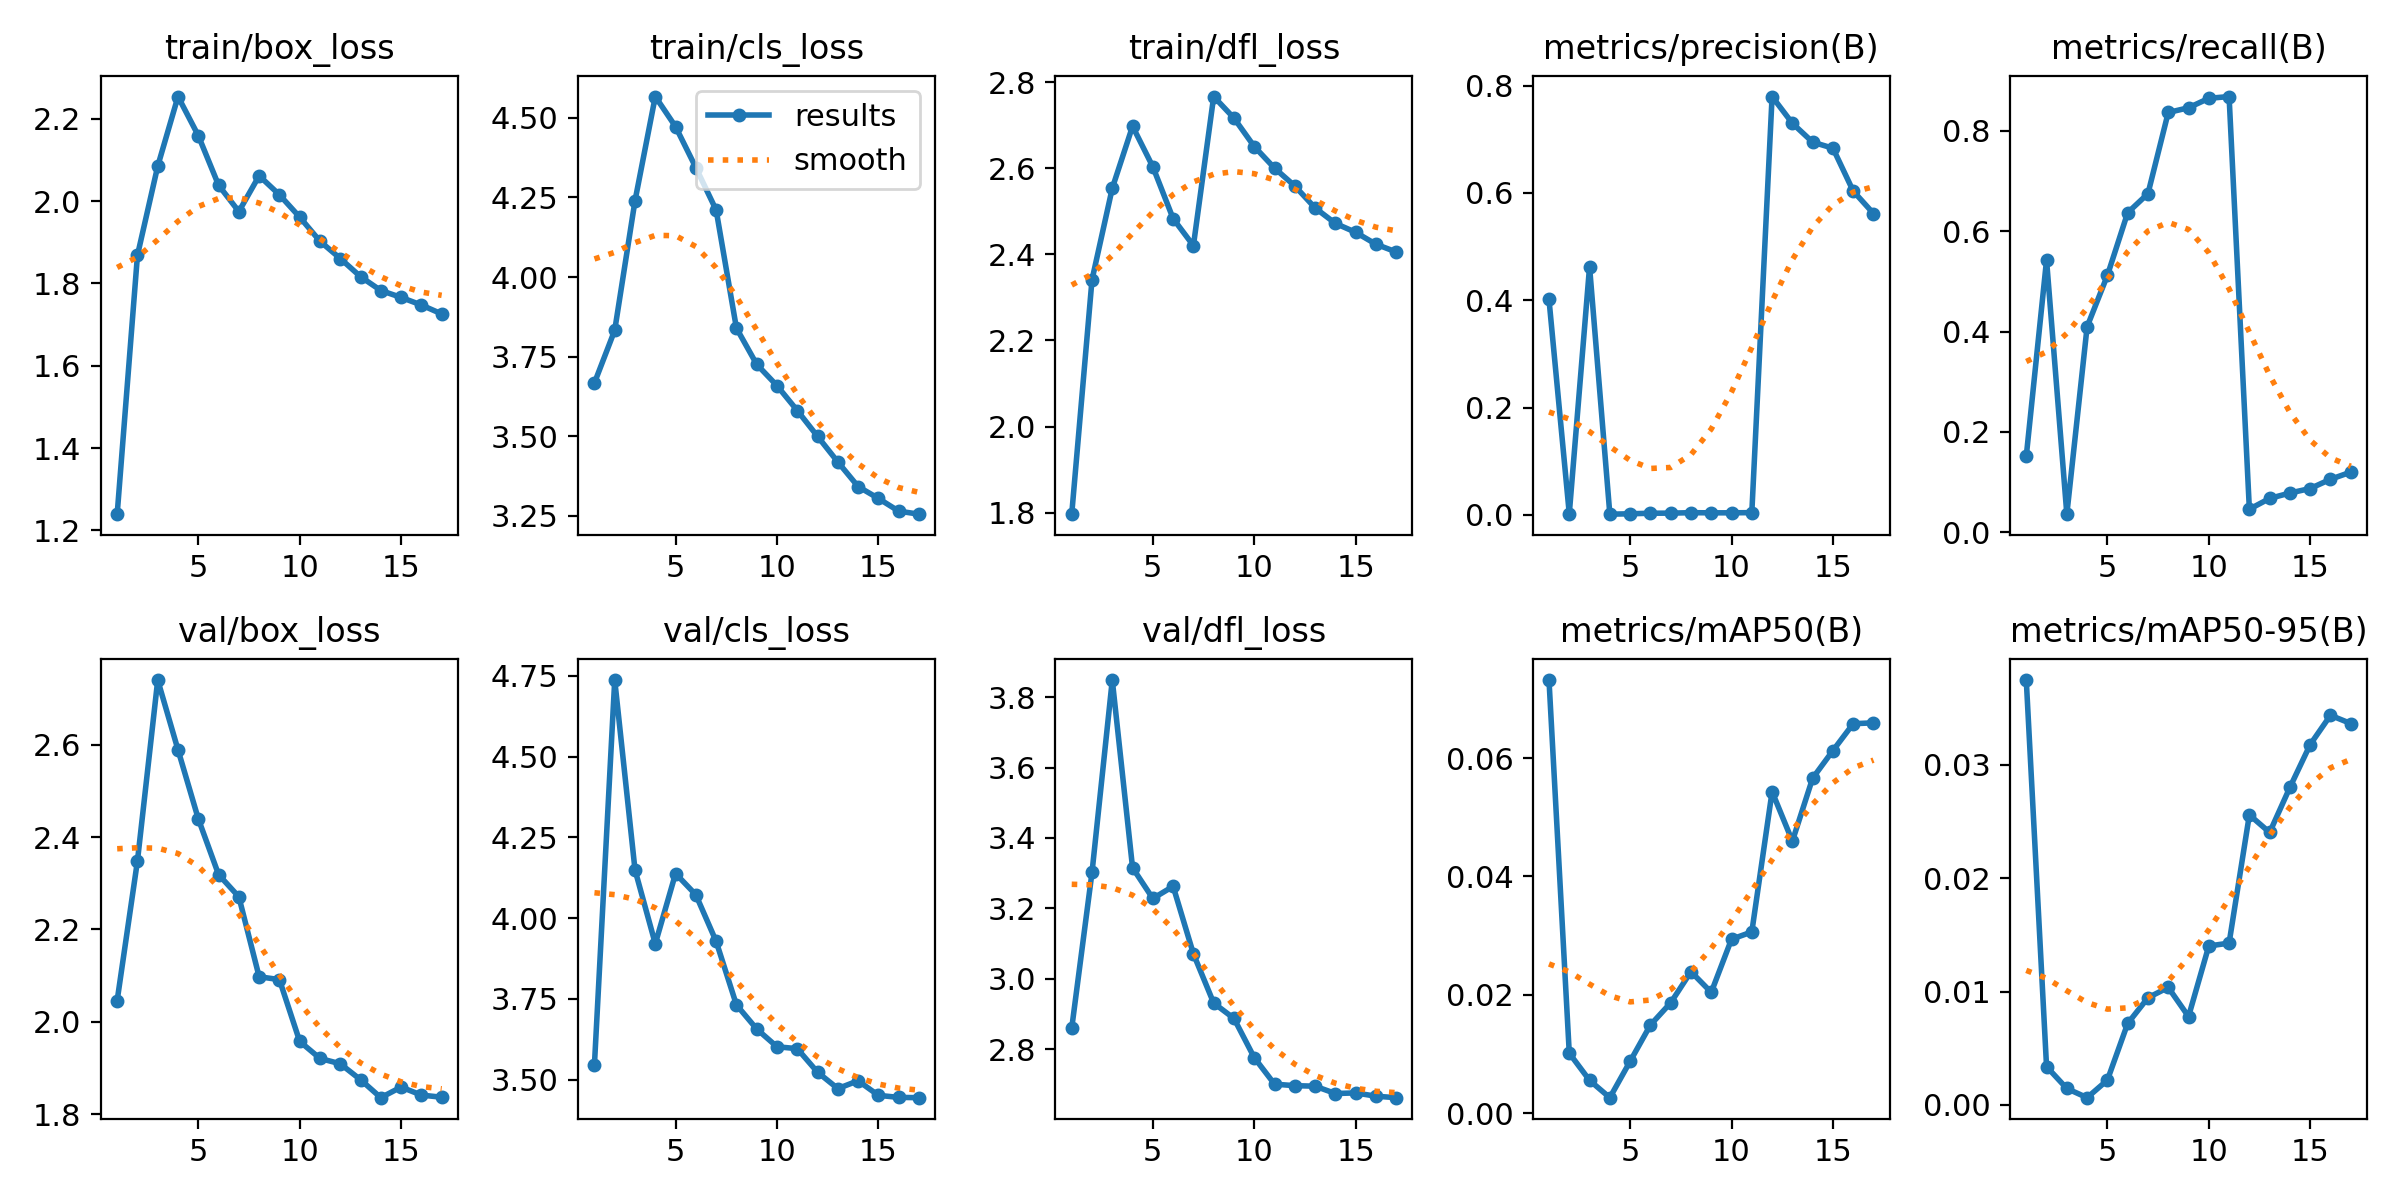

In [50]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

### Load Test Dataset and Display Classes

In [51]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{DATASET_PATH}/test/images",
    annotations_directory_path=f"{DATASET_PATH}/test/labels",
    data_yaml_path=DATA_YAML_PATH
)

ds.classes

['cap_nia_bac',
 'cap_nia_nam',
 'cap_nong',
 'ho_mang_chua',
 'ho_mang_xiem',
 'khiem_vach',
 'luc_cuom',
 'luc_nua',
 'luc_xanh',
 'luc_xanh_duoi_do',
 'ran_cuom',
 'ran_dai_lon',
 'ran_hoa_can_van_dom',
 'ran_hoa_co_do',
 'ran_rao',
 'ran_rao_trau',
 'ran_ri_ca',
 'ran_roi',
 'ran_sai_co',
 'ran_soc_dua',
 'ran_soc_go',
 'ran_trun']

### Calculate Mean Average Precision (mAP)

In [52]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

### Print mAP Scores

In [53]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.004802623119454802

mAP 50 0.009868844027259868

mAP 75 0.0030603060306030605

### Plot mAP Curve

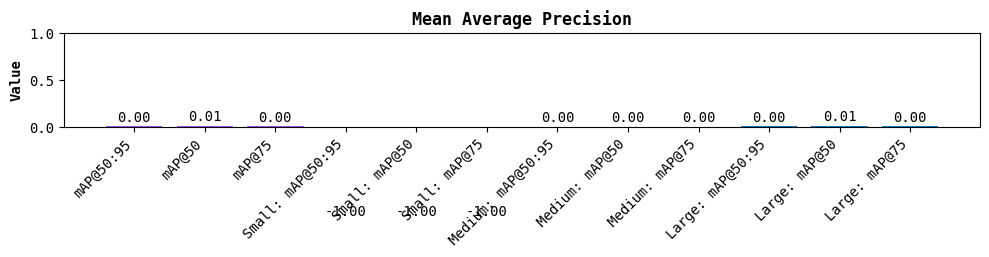

In [54]:
map.plot()

# Run inference with fine-tuned YOLOv12 model

In [55]:
import supervision as sv

model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{DATASET_PATH}/test/images",
    annotations_directory_path=f"{DATASET_PATH}/test/labels",
    data_yaml_path=DATA_YAML_PATH
)

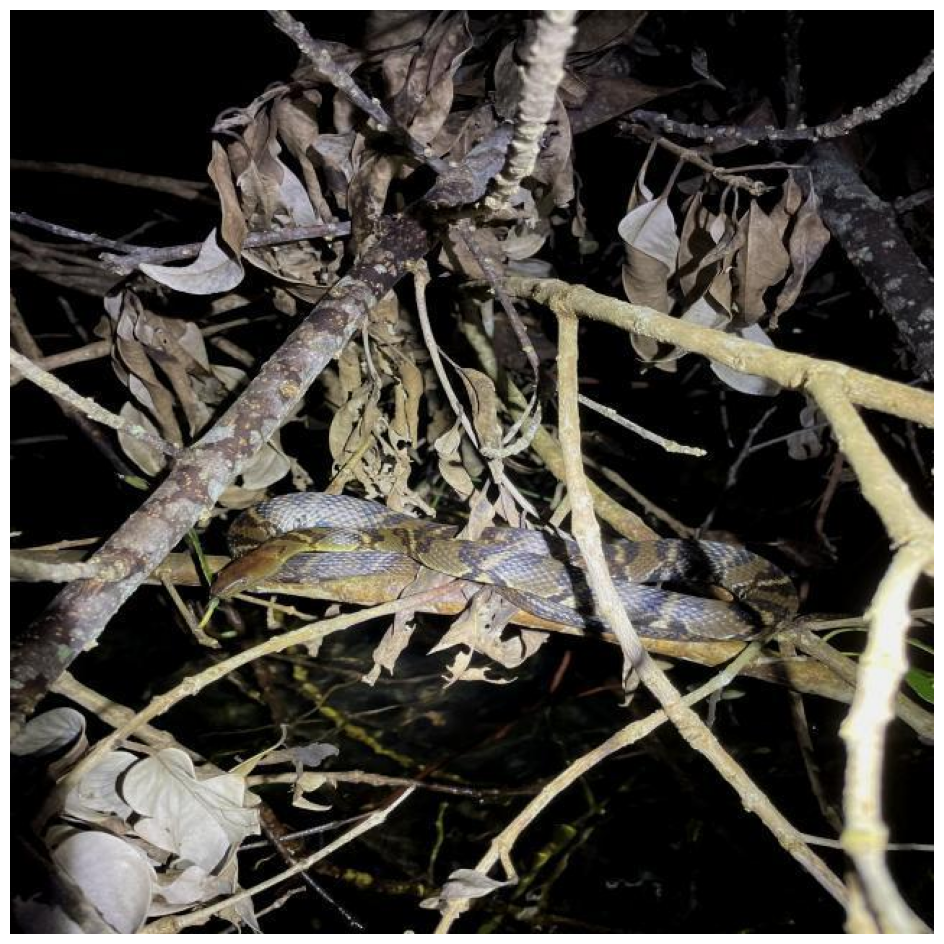

In [56]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

# Call tắt laptop sau khi train xong

In [57]:
import requests

WEBHOOK_URL = "https://forcepslike-lawanda-semicalcined.ngrok-free.dev/done"  # đổi URL của bạn

try:
    r = requests.post(WEBHOOK_URL)
    print("Đã gửi tín hiệu shutdown về PC!")
except Exception as e:
    print("Không gửi được webhook:", e)

Đã gửi tín hiệu shutdown về PC!